In [ ]:
# FUNCTIONS

#ActivityCodes (0=sedentary 1=standing 2=stepping 2.1=cycling 3.1=primary lying, 3.2=secondary lying 4=non-wear 5=travelling)
def reassign_classes(classes):
  for count, value in enumerate(classes):
    if classes[count] == 2.1:
      classes[count] = 2
    elif classes[count] == 3.1:
      classes[count] = 3
    elif classes[count] == 3.2:
      classes[count] = 3
    elif classes[count] == 5.0:
      classes[count] = 0
    else:
      continue
  return classes

# Removing non-wear because it destroys the NN
def remove_classes(dataset, stack, class_to_remove):
  remove_non_wear_idx = posture_classes != class_to_remove
  stack = stack[remove_non_wear_idx]
  dataset = dataset[remove_non_wear_idx]
  return dataset, stack

# Reshape the data for specific models
def reshape_set(dataset, new_shape):
  shaper = dataset.shape
  new_shape.insert(0, shaper[0])
  new_shape = tuple(new_shape)
  dataset = dataset.reshape(new_shape)
  return dataset

def one_hot_data(stack):
  unique_classes = np.unique(stack)
  stack = tf.one_hot(stack, len(unique_classes))
  return stack

def review_class_imbalance(y_train, y_test, labels=None):
  # Find the unique label values...
  unique_classes_train = np.unique(y_train)
  unique_classes_test = np.unique(y_test)
  # Count the unique label values
  unique_train, counts_train = np.unique(y_train, return_counts=True)
  unique_test, counts_test = np.unique(y_test, return_counts=True)
  try:
    count_class_values_train = dict(zip(labels, counts_train))
    count_class_values_test = dict(zip(labels, counts_test))
  except:
    count_class_values_train = dict(zip(unique_train, counts_train))
    count_class_values_test = dict(zip(unique_test, counts_test))

  print('Train Classes')
  print(count_class_values_train)
  print('--------------')
  print('Test Classes')
  print(count_class_values_test)
  print('--------------')
  return unique_classes_train, unique_classes_test

def norm_accel_data(x):
  """
  Processes accel values and returns a normalised integer (0-1).
  """
  x_minimum = 0
  x_maximum = 255
  x_normalized = ((x - x_minimum) / (x_maximum - x_minimum))
  return x_normalized

def process_epochs(x, y=None, shuffle=False):
  """
  Processing epochs
  """
  print("Creating training data...")
  # Normalize the acceleration data
  x = norm_accel_data(x)
  # Convert data to a tensor
  data = tf.constant(x)
  # If the data is a training dataset, we shuffle it
  if shuffle:
    indices = tf.range(start=0, limit=tf.shape(data)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices)
    shuffled_x = tf.gather(x, shuffled_indices)
    shuffled_y = tf.gather(y, shuffled_indices)
    return shuffled_x, shuffled_y
  else:
    return data

def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions, normalize ='true')
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def show_training(history):
  # summarize history for accuracy
  plt.figure(figsize=(10, 4))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(10, 4))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

def show_model_results(model_to_test, data_to_test, validation):
  predictions = model_to_test.predict(data_to_test)
  predictions_max = np.argmax(predictions, axis=1)

  show_confusion_matrix(validation, predictions_max)
  print('------------')
  print(classification_report(validation, predictions_max))

def train_and_save_model(model_to_train, X_train, y_train, model_name):

  callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

  # Hyper-parameters
  EPOCHS = 50

  model_to_train.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
  
  history = model_to_train.fit(X_train,
                  y_train,
                  epochs=EPOCHS,
                  validation_split=0.2,
                  batch_size=32,
                  #callbacks=[callback],
                  verbose=1)

  show_training(history)

  filename  = '/content/drive/MyDrive/Documents/Work/UOS Post-Doc/Amputee Posture Classification/models/' + model_name + '.h5'

  # save the model
  model_to_train.save(filename)

In [ ]:
!pip install pyyaml h5py
import numpy as np
import tensorflow as tf
print("TF version:", tf.__version__)

# Import more tools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

# Check for GPU availability
print("GPU", "available 🤗" if tf.config.list_physical_devices("GPU") else "not available 😟")

print('------------')

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

TF version: 2.4.1
GPU available 🤗
------------


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5560913155480457682, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7696497072370694550
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

engineering_set1 = np.load('/content/drive/MyDrive/Documents/Work/UOS Post-Doc/Amputee Posture Classification/data/1_pure_engineering_set.npy')
posture_classes1 = np.load('/content/drive/MyDrive/Documents/Work/UOS Post-Doc/Amputee Posture Classification/data/1_pure_engineering_set_classes.npy')
engineering_set2 = np.load('/content/drive/MyDrive/Documents/Work/UOS Post-Doc/Amputee Posture Classification/data/2_pure_engineering_set.npy')
posture_classes2 = np.load('/content/drive/MyDrive/Documents/Work/UOS Post-Doc/Amputee Posture Classification/data/2_pure_engineering_set_classes.npy')
engineering_set3 = np.load('/content/drive/MyDrive/Documents/Work/UOS Post-Doc/Amputee Posture Classification/data/3_pure_engineering_set.npy')
posture_classes3 = np.load('/content/drive/MyDrive/Documents/Work/UOS Post-Doc/Amputee Posture Classification/data/3_pure_engineering_set_classes.npy')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
engineering_set = np.concatenate((engineering_set1, engineering_set2, engineering_set3), axis=0)
posture_classes = np.concatenate((posture_classes1, posture_classes2, posture_classes3), axis=0)

In [ ]:
# Main Processing
posture_classes = reassign_classes(posture_classes)
engineering_set, posture_classes = remove_classes(engineering_set, posture_classes, 4)

X_train, X_test, y_train, y_test = train_test_split(engineering_set, posture_classes, test_size=0.2, random_state=42)

y_train_hot = one_hot_data(y_train)
y_test_hot = one_hot_data(y_test)

#X_train_shuffled, y_train_hot_shuffled = process_epochs(X_train, y_train_hot, shuffle=True)
#X_test_shuffled, y_test_hot_shuffled = process_epochs(X_test, y_test_hot, shuffle=True)

X_train_reshaped = reshape_set(X_train, [1,295,3])
X_test_reshaped = reshape_set(X_test, [1,295,3])

X_train = process_epochs(X_train)
X_test = process_epochs(X_test)
X_train_reshaped = process_epochs(X_train_reshaped)
X_test_reshaped = process_epochs(X_test_reshaped)



Creating training data...
Creating training data...
Creating training data...
Creating training data...


In [ ]:
LABELS = ['Sedentary', 'Standing', 'Stepping', 'Lying']

unique_classes_train, unique_classes_test = review_class_imbalance(y_train, y_test, LABELS)

INPUT_SHAPE = X_train.shape[1:]
print('input shape:', INPUT_SHAPE)

INPUT_SHAPE_RESHAPED = X_train_reshaped.shape[1:]
print('input shape reshaped:', INPUT_SHAPE_RESHAPED)

OUTPUT_SHAPE = len(unique_classes_train)
print('output shape:', OUTPUT_SHAPE)

Train Classes
{'Sedentary': 54798, 'Standing': 35903, 'Stepping': 11478, 'Lying': 54909}
--------------
Test Classes
{'Sedentary': 13744, 'Standing': 8982, 'Stepping': 2876, 'Lying': 13670}
--------------
input shape: (295, 3)
input shape reshaped: (1, 295, 3)
output shape: 4


In [ ]:
# My Experiments

# Model - DNN
dnn_model = tf.keras.Sequential([
                                 tf.keras.Input(shape=INPUT_SHAPE_RESHAPED),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 tf.keras.layers.Dense(100, activation='relu'),
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(OUTPUT_SHAPE, activation='softmax')],
                                 name='DNN-Model')

# Model - CNN
cnn_model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(32, kernel_size = (1, 12),
                                                    strides = (1, 1),
                                                    input_shape=INPUT_SHAPE_RESHAPED,
                                                    padding="valid"),
                             tf.keras.layers.MaxPooling2D((1,4), (1, 2)),
                             tf.keras.layers.Conv2D(64, kernel_size = (1, 4),
                                                    strides = (1, 1),
                                                    input_shape = (1, 295, 3),
                                                    padding="valid"),
                             tf.keras.layers.MaxPooling2D((1,4), (1, 2)),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(OUTPUT_SHAPE, activation='softmax')],
                             name='CNN-Model')

# Model - LSTM
lstm_model = tf.keras.Sequential([
                              tf.keras.layers.LSTM(128, input_shape=INPUT_SHAPE),
                              tf.keras.layers.Dense(100, activation='relu'),
                              tf.keras.layers.Dense(OUTPUT_SHAPE, activation='softmax')],
                              name='LSTM-Model')

# Model - GRU (this model has already been trained and saved)
gru_model = tf.keras.Sequential([
                              tf.keras.Input(shape=INPUT_SHAPE),
                              tf.keras.layers.GRU(256, return_sequences=True),
                              tf.keras.layers.SimpleRNN(128),
                              tf.keras.layers.Dense(100, activation='relu'),
                              tf.keras.layers.Dense(OUTPUT_SHAPE, activation='softmax')],
                              name='GRU-Model')

print(dnn_model.summary())
print(cnn_model.summary())
print(lstm_model.summary())
print(gru_model.summary())

In [ ]:
# Training and saving the models
#train_and_save_model(dnn_model, X_train_reshaped, y_train_hot, 'dnn_model')
#train_and_save_model(cnn_model, X_train_reshaped, y_train_hot, 'cnn_model')
#train_and_save_model(lstm_model, X_train, y_train_hot, 'lstm_model')
#train_and_save_model(gru_model, X_train, y_train_hot, 'rnn_model4')

Model: "DNN-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1, 295, 100)       400       
_________________________________________________________________
dense_21 (Dense)             (None, 1, 295, 100)       10100     
_________________________________________________________________
dense_22 (Dense)             (None, 1, 295, 100)       10100     
_________________________________________________________________
flatten_4 (Flatten)          (None, 29500)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 118004    
Total params: 138,604
Trainable params: 138,604
Non-trainable params: 0
_________________________________________________________________


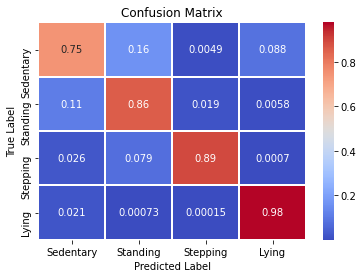

------------
              precision    recall  f1-score   support

           0       0.88      0.75      0.81     13744
           1       0.76      0.86      0.81      8982
           2       0.91      0.89      0.90      2876
           3       0.91      0.98      0.94     13670

    accuracy                           0.86     39272
   macro avg       0.87      0.87      0.87     39272
weighted avg       0.87      0.86      0.86     39272

------------------------------------------------------------------------------------------------
Model: "CNN-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1, 284, 32)        1184      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 141, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1

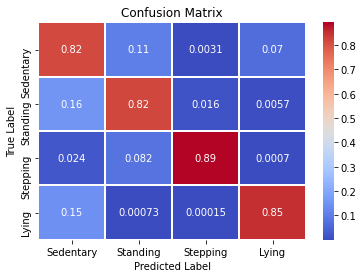

------------
              precision    recall  f1-score   support

           0       0.77      0.82      0.79     13744
           1       0.81      0.82      0.82      8982
           2       0.93      0.89      0.91      2876
           3       0.92      0.85      0.89     13670

    accuracy                           0.84     39272
   macro avg       0.86      0.85      0.85     39272
weighted avg       0.84      0.84      0.84     39272

------------------------------------------------------------------------------------------------
Model: "LSTM-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dense_26 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_27 (Dense)             (None, 4) 

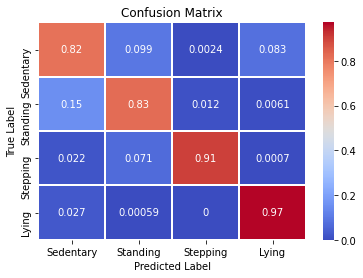

------------
              precision    recall  f1-score   support

           0       0.86      0.82      0.84     13744
           1       0.83      0.83      0.83      8982
           2       0.95      0.91      0.93      2876
           3       0.92      0.97      0.94     13670

    accuracy                           0.88     39272
   macro avg       0.89      0.88      0.88     39272
weighted avg       0.88      0.88      0.88     39272

------------------------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 295, 256)          200448    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense (Dense)                (None, 100

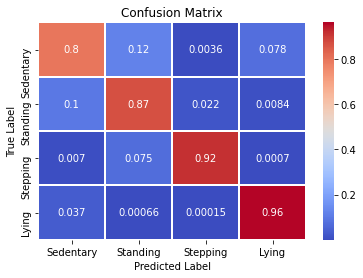

------------
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     13744
           1       0.81      0.87      0.84      8982
           2       0.91      0.92      0.92      2876
           3       0.92      0.96      0.94     13670

    accuracy                           0.88     39272
   macro avg       0.88      0.89      0.88     39272
weighted avg       0.88      0.88      0.88     39272



In [ ]:
valid = np.argmax(y_test_hot, axis=1)

# ---------- DNN Model ----------
# Recreate the exact same model, including its weights and the optimizer
dnn_model_loaded = tf.keras.models.load_model('/content/drive/MyDrive/Documents/Work/UOS Post-Doc/Amputee Posture Classification/models/dnn_model.h5')
# Show the model architecture
dnn_model_loaded.summary()
# Show results
show_model_results(dnn_model_loaded, X_test_reshaped, valid)

print('------------------------------------------------------------------------------------------------')

# ---------- CNN Model ----------
# Recreate the exact same model, including its weights and the optimizer
cnn_model_loaded = tf.keras.models.load_model('/content/drive/MyDrive/Documents/Work/UOS Post-Doc/Amputee Posture Classification/models/cnn_model.h5')
# Show the model architecture
cnn_model_loaded.summary()
# Show results
show_model_results(cnn_model_loaded, X_test_reshaped, valid)

print('------------------------------------------------------------------------------------------------')

# ---------- LSTM Model ----------
# Recreate the exact same model, including its weights and the optimizer
lstm_model_loaded = tf.keras.models.load_model('/content/drive/MyDrive/Documents/Work/UOS Post-Doc/Amputee Posture Classification/models/lstm_model.h5')
# Show the model architecture
lstm_model_loaded.summary()
# Show results
show_model_results(lstm_model_loaded, X_test, valid)

print('------------------------------------------------------------------------------------------------')

# ---------- GRU Model ----------
# Recreate the exact same model, including its weights and the optimizer
gru_model_loaded = tf.keras.models.load_model('/content/drive/MyDrive/Documents/Work/UOS Post-Doc/Amputee Posture Classification/models/rnn_model.h5')
# Show the model architecture
gru_model_loaded.summary()
# Show results
show_model_results(gru_model_loaded, X_test, valid)